# HDI Technical Challenge: Data Science - Bike Sharing
![bikeimg](./bikeimg.jpg)

This is my (Pascal Bliem's) solution to the HDI Technical Challenge for Data Science. In this challenge I will make future usage predictions for a bike sharing program. I will be using a public data set from [Capital Bikeshare](https://www.capitalbikeshare.com/system-data), which was provided to the [UCI Machine learning repository](http://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset) by Hadi Fanaee-T from the Laboratory of Artificial Intelligence and Decision Support (LIAAD), University of Porto. The company offers services in Washington D.C., U.S.A., a city with a humid subtropical climate (Köppen climate classification Cfa) with hot and humid summers and cold winters.

In this notebook I will go through the following 5 questions:
1. [Usefulness of data for training a predictive model](#q1)
2. [Discussion of Variables/Features](#q2)
3. [Training a linear regression model](#q3)
    - [3a. Preprocessing the data](#q3a)
    - [3b. Categorical variables](#q3b)
    - [3c. Dimensionality issues](#q3c)
    - [3d. Most effective features](#q3d)
    - [3e. Model performance](#q3e)
    - [3f. Improving the model](#q3f)
4. [Query the data with SQL and pandas](#q4)
5. [Merging existing and new data with SQL and pandas](#q5)

[Conclusion](#con)

Before I approach these questions, I will first import libraries and explore the data a bit. If you would like to jump to the first question right away, just click [here](#q1).

In [1]:
# import libaries 

# for numerical calculations
import numpy as np 
# for data handling and processing
import pandas as pd 
# for plotting/visualizing data
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline
import warnings
# ignore annoying warnings for the display here 
# (of course I've read them)
warnings.filterwarnings("ignore")


## Explore the data set
Let's have a look at the data set first. We can find a description of the variables [online](http://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset) together with the data set:

```
- instant: record index
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered
```
As we can see, the data set contains information on how many bikes were rented at what time, as well as plenty of situational information on weather and type of day (workday, holiday etc.)

I will first load the data and print some summarizing information.

In [2]:
# load the data from the CSV file into a pandas data frame
data = pd.read_csv("DataScience_Challange_bike_share.csv")

# have a look at the first 5 rows
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [3]:
# get an overview of column names, data types, and number of entries
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
instant       731 non-null int64
dteday        731 non-null object
season        731 non-null int64
yr            731 non-null int64
mnth          731 non-null int64
holiday       731 non-null int64
weekday       731 non-null int64
workingday    731 non-null int64
weathersit    731 non-null int64
temp          731 non-null float64
atemp         731 non-null float64
hum           731 non-null float64
windspeed     731 non-null float64
casual        731 non-null int64
registered    731 non-null int64
cnt           731 non-null int64
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


We can see that there are 731 instances (rows) in this data set, each row corresponds to one day.
The columns show values for the variables representing the previously mentioned information. We can have a look how the number of rentals developes as a function of the date.

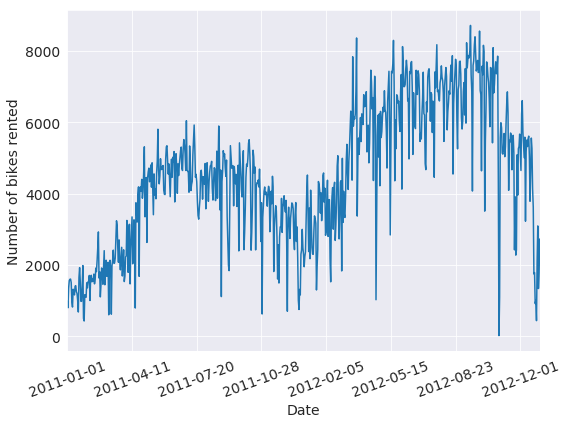

In [4]:
# plot the number of bike rentals as a function of the date
data.plot("dteday","cnt",rot=20,figsize=(8,6),fontsize=14,legend=False)
plt.gca().set_xlabel("Date",fontsize=14)
plt.gca().set_ylabel("Number of bikes rented",fontsize=14)
plt.tight_layout()

We can see that the dates range from Janurary 2011 till beginning of December 2012, almost two years. We can also see that the overall trend of bike rentals seems to be increasing and that there are strong local fluctuations as well as a clear seasonal trend (higher number of rentals during the summer months).

Let's have a look on how the values of the rest of the variables are distributed by looking at the corresponding histograms.

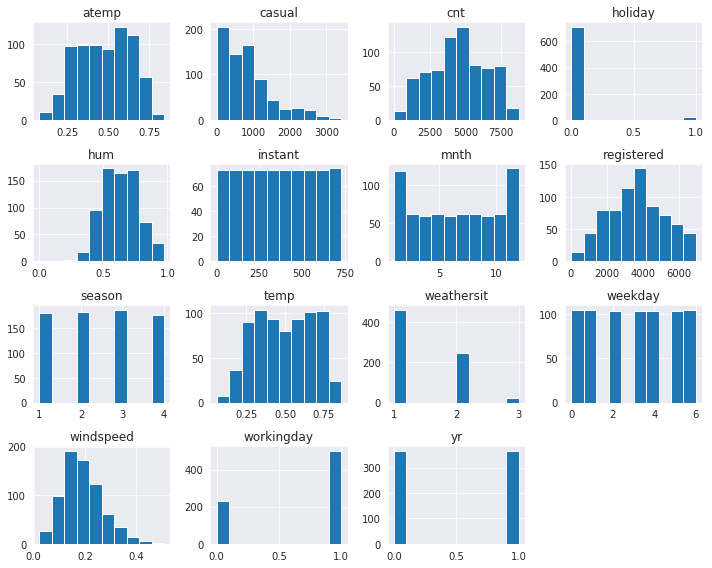

In [5]:
# plot histograms to display the distribution of the data
data.hist(figsize=(10,8))
plt.tight_layout()

We can see that there are no significant outliers. There are a few interesting things to note, for example, the total count of rentals and registered users are approximately normally distributed, whereas the number of casual users is highly skewed to the lower end of the distribution. Extreme weather situations are rare and temperatures, and probably also humidity, follow bimodal distributions, which is probably related to seasonal weather changes.

Now I will start with answering the questions.

## 1. Usefulness of data for training a predictive model <a id="q1"></a>
The first question reads:
> *"Do you think the included data will be useful in training a predictive model for this
purpose? Which variables would you expect to have some effect on the number of
shared bikes on a given day? Explain your reasoning."*

Most of the provided data seems to have a lot of potential for being useful in training a model. Since riding a bike (and hence, renting one) is an outdoor activity, the count of rentals can be expected to be strongly correlated with weather conditions (`weathersit`, `temp`, `atemp`, `hum`, `windspeed`). People are probably willing to take a bike rather than car or public transportaion if the temparatuers are not too cold, it's not raining or snowing, and the wind is not too strong. As we can see in the plots below, the number of rentals is strongly positively correlated to the feeling temperature and negatively correlated to the wind speed and the harshnes of weather situation.

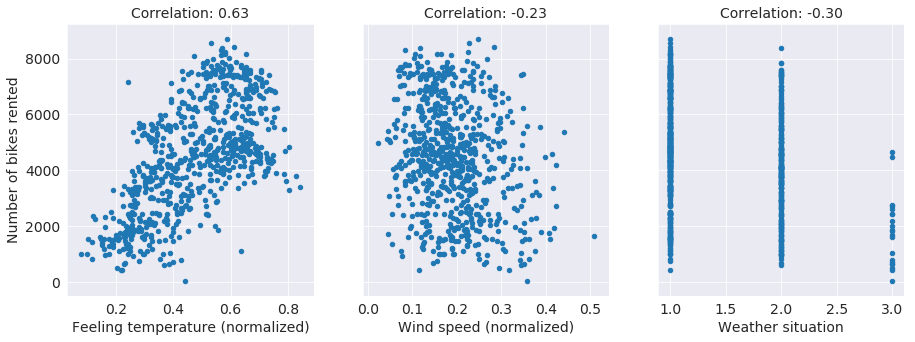

In [6]:
# initialize subplots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3,sharey=True,figsize=(15,5))

# plot bike rentals as a function of feeling temperature
data.plot.scatter(x="atemp",y="cnt",ax=ax1,fontsize=14)
ax1.set_ylabel("Number of bikes rented",fontsize=14)
ax1.set_xlabel("Feeling temperature (normalized)",fontsize=14)
ax1.set_title(f"Correlation: {data.corr().cnt.atemp:.2f}",fontsize=14)

# plot bike rentals as a function of wind speed
data.plot.scatter(x="windspeed",y="cnt",ax=ax2,fontsize=14)
ax2.set_xlabel("Wind speed (normalized)",fontsize=14)
ax2.set_title(f"Correlation: {data.corr().cnt.windspeed:.2f}",fontsize=14)

# plot bike rentals as a function of weather situation
data.plot.scatter(x="weathersit",y="cnt",ax=ax3,fontsize=14)
ax3.set_xlabel("Weather situation",fontsize=14)
_ = ax3.set_title(f"Correlation: {data.corr().cnt.weathersit:.2f}",fontsize=14)

As mentioned before, the months and seasons, and hence the number of biike rentals, will be highly correlated with the weather. In Washington D.C., warmer weather can be expected during the summer months and colder, harsher weather during the winter months. 

The correlation of bike rentals to variables such as day of the week, working day, or holiday, may be less pronounced. During working days, people will likely use bikes for their commute to work. During weekends and holidays, people may be icentivized to use bikes for recreational purpose. This may lead to similar number of rentals for all sorts of days. We can see in the plots below, that the correlations are indeed very small.

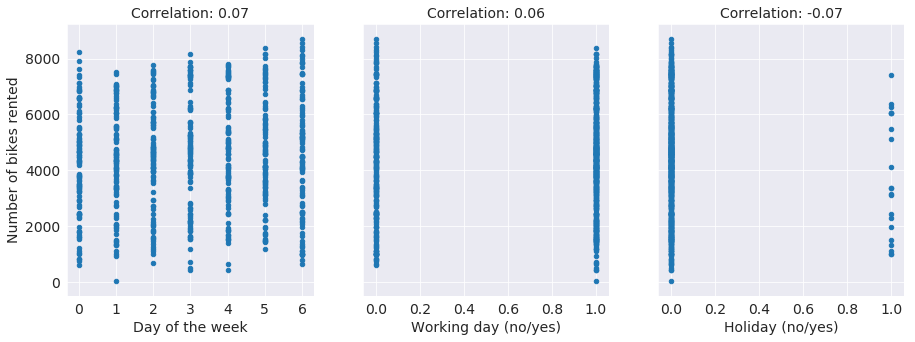

In [7]:
# initialize subplots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3,sharey=True,figsize=(15,5))

# plot bike rentals as a function of week day
data.plot.scatter(x="weekday",y="cnt",ax=ax1,fontsize=14)
ax1.set_ylabel("Number of bikes rented",fontsize=14)
ax1.set_xlabel("Day of the week",fontsize=14)
ax1.set_title(f"Correlation: {data.corr().cnt.weekday:.2f}",fontsize=14)

# plot bike rentals as a function of working day
data.plot.scatter(x="workingday",y="cnt",ax=ax2,fontsize=14)
ax2.set_xlabel("Working day (no/yes)",fontsize=14)
ax2.set_title(f"Correlation: {data.corr().cnt.workingday:.2f}",fontsize=14)

# plot bike rentals as a function of holiday
data.plot.scatter(x="holiday",y="cnt",ax=ax3,fontsize=14)
ax3.set_xlabel("Holiday (no/yes)",fontsize=14)
_ = ax3.set_title(f"Correlation: {data.corr().cnt.holiday:.2f}",fontsize=14)

## 2. Discussion of Variables/Features <a id="q2"></a>
The second question reads:
> *"Which feature represents the dependent variable and which ones would you consider independent variables for this problem? Which columns can you discard since they do not provide valuable information? Would you expect high correlation between some of the variables? What should we do with these correlated variables?"*

The dependent variable is the one that has to be predicted (and hence, depends on other variables). In this case it is the number of bike rentals, `cnt`. We also have information about how many rentals are from `registered` and `casual` users. These are, of course, dependent variables as well and we can obviously not use them for prediction because that would be a severe case of data leakage (using information that would not actually be available for prediction in a real use case).

The other variables can be considered as independent variables, as I am not trying to predict them based on other variables. There is, however, a lot of redundant information encoded in them. For example, knowing if it's a holiday or weekend also let's us know if it's  a working day or not. Given the month, we also know the season. The year may be useful though, because we have observed a general upwards trend. The feeling (or [apparent](https://en.wikipedia.org/wiki/Apparent_temperature)) temperature is calculated from the temperature, humidity, and wind speed. Some of the information may not be totally redundant though, since e.g. the wind speed may not only influence the apparent temperature, but may also have a separate influence on bike rentals because biking takes more effort with strong headwinds.

Since the term *feature* is more commonly used in a machine learning context, I will say *feature* instead of *variable* in the following. We may remove redundant or uninformative features (such as the day-based information which shows very little correlation to the number of rentals) to reduce the amount of data and speed up the training and prediction. But besides the speed-up, reducing the number of dimensions may result in better performance, which I will discuss in more detail in the answer to question [3c](#q3c). If we have the time and resources, we can treat the choice of features as a hyper-parameter (a parameter that isn't learned during training but chose beforehand), train several models with different choices, and see which performs the best. Last but not least, since I will be using a linear regression, I must not include features that a perfectly linearly correlated (multicollinearity), which would violate an [assumption](https://en.wikipedia.org/wiki/Linear_regression#Assumptions) of linear regression because then there would be no unique solution for the estimator parameter vector.

I chose to proceed with the features `yr`, `mnth`, `workingday`, `weathersit`, `windspeed`, and `atemp` to predict the number of rentals, `cnt`, and I will drop the other features for now.

In [8]:
# drop the unneeded features
selected_data = data.drop(["dteday","instant","season","holiday","weekday","temp","hum","casual","registered"]
                          ,axis=1)
selected_data.head()

,yr,mnth,workingday,weathersit,atemp,windspeed,cnt
0,0,1,0,2,0.363625,0.160446,985
1,0,1,0,2,0.353739,0.248539,801
2,0,1,1,1,0.189405,0.248309,1349
3,0,1,1,1,0.212122,0.160296,1562
4,0,1,1,1,0.229270,0.186900,1600


Before I start training the model, I should split the data into a train, validation, and test set. The reason we need the validation set is to prevent the model from over-fitting on the training data. I need to calculate a score on new data that was not used in training to evaluate the model's ability to generalize to unseen data. I will also use this score to optimize the hyper-parameters of the model. Of course, this means there is a risk of slightly over-fitting on the validation set as well. Therefore I will also put aside a test set to evaluate the models final performance on data that it has not seen at any point.

When dealing with time series data, I cannot just randomly shuffle instances to split the data set because that would destroy the chronological order (and I don't have a time machine). Since there are only 2 years of data, choosing the right split is not trivial. The training data has to reflect the seasonal trend as well as the overall trend, therefore, I allocate the first 70% of data to the train set, 15% to the validation set, and another 15% to the test set. If there was more data over more years available, I would have increased the size of validation and test sets. The features will be denoted as `X`, whereas the target values will be denoted as `y`.

In [9]:
# get index for 70% training data, 15% validation data, 15% test data
train_idx = int(0.7 * len(data))
valid_idx = int(0.85 * len(data))

# the training set, features X and targets y
X_train = selected_data[:train_idx].drop("cnt",axis=1)
y_train = selected_data[:train_idx].cnt

# the validation set, features X and targets y
X_valid = selected_data[train_idx:valid_idx].drop("cnt",axis=1)
y_valid = selected_data[train_idx:valid_idx].cnt

# the test set, features X and targets y
X_test = selected_data[valid_idx:].drop("cnt",axis=1)
y_test = selected_data[valid_idx:].cnt

## 3. Training a linear regression model <a id="q3"></a>
The second question reads:
> *"Train a linear regression model on the independent variable using your chosen dependent features. (Please use Python or R)"*

<a id="q3a"></a>
> *"a. How do you preprocess your data? Are there missing values? What would you do if you had missing values? When do you think standardization would be necessary?"*

Let's address the individual points of this question one after the other, starting with missing values. I will have a look if there are any.

In [10]:
# look for missing (NaN encoded) values
print(f"Number of missing values:\n{data.isna().sum()}\n")

# check the data types
print(f"Data types:\n{data.dtypes}")

Number of missing values:
instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

Data types:
instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object


There are apparently no missing values and none of the columns has a mixed data type, which suggests that there are also no missing values encoded as strings. We have previously seen in the histograms that there are no outliers with suggests that no missing values are encoded as large integer values. Furthermore, the data set documentation does not mention any missing values or their encodings.

If there were missing values, there are a few strategies to handle them. If there are not to many and it is possible to look up the missing data (e.g. the weather), one can manually fill in the missing values. If there are not too many missing values, one can also consider simply dropping the corresponding instances. Another way could be to imputer the values. There are a couple of different ways to impute: for categorical values one could impute with the most frequently occurring value, for numerical values one could impute with the mean or median. For sequential data like time series (like in this example) it may make more sense to consider the chronological aspect and impute values by forward filling, backward filling, or filling by rolling window averages. If the time and resources allow for training several models, one can treat the missing value handling as a part of the hyper-parameter optimization. Note that it is important to use the imputation value that was used for the train set also for the validation and test set.

Let's talk about standardization, which means transforming the values of a feature so that the range of all values (usually) has a mean of zero and variance of one. This can have several advantages: Many machine learning algorithms optimize their parameters during training by algorithms form the [gradient decent](https://en.wikipedia.org/wiki/Gradient_descent) family. They calculate the partial gradient of each feature and adjust parameters accordingly to decent that gradient and minimize a specified loss function. If all features are on the same scale, these descending steps are of similar size which usually leads to faster convergence, hence, less training time. Because I am not dealing with many features here, I will actually use an implementation of linear regression that optimizes its parameters by solving the [normal equation](https://en.wikipedia.org/wiki/Linear_least_squares) instead of employing gradient decent, but for scenarios with many features, it may be more efficient to use an implementation with a gradient decent type optimizer.

Another benefit of standardization with respect to linear models, like linear regression, is that it allows to see the influence of each feature on the predicted value by directly looking at the fitted parameters. In a linear regression, these parameters (often also called coefficients) are scaling factors that determine how much the value of a feature contributes to the predicted values. If the features are on the same scale these coefficients are directly comparable and can tell how much a feature is positively or negatively correlated with the predicted value.

For these reasons, I will use standardization for the numerical features, which I will implement with `Sci-kit Learn`'s `StandardScaler`. Note that the scaler will be fitted on the training data and the same learned transformation will be applied to the validation and test data.

<a id="q3b"></a>
> b. *"What about categorical variables? When does label encoding make sense?"*

There are different options for encoding categorical features. The models only take numbers, so if there are any strings as feature values, they would definitely have to be encoded. We do not have any string values in this example. If the categorcial features are ordinal, which means the have a natural order, it makes sense to chose an encoding which preserves this order. This applies to the year and month in this example. I would say that it also applies to the weather situation, since the weather get's increasingly harsher. 

Catergorical features that are nominal, which means they have no natural order, can be one-hot encoded. This means that each value the feature can take is represented as its own column which can either take the value 1 if this particular value was present, or 0 if it was not. This applies to the working day feature in this example; either it's a working day or not, 1 or 0. Luckily, all features already have a suitable encoding, so there is no need for further preprocessing. If that wouldn't be the case, the `Sci-kit Learn` library offeres many conveinient preprocessing methods such as the `LabelEnddoder` for ordinal features and the `OneHotEncoder` for nominal features.

If a nominal categorical feature can take many possible values, one-hot encoding can add a lot of additional dimensions which may hurt the model's performance. This could, for example, be the case in text processing when these values are words in a vocabulary. In such cases, values may be represented by so-called embeddings, which are vector representations. Each value is represeneted as a dense vector and the location of the vector in the embedding space can be learned unsupervised e.g. by algorithms such as [word2vec](https://en.wikipedia.org/wiki/Word2vec) or [GloVe](https://nlp.stanford.edu/projects/glove/) or in an embedding layer as a part of a supervised model.

<a id="q3c"></a>
> c. *"How many dimensions do you have after preprocessing? Is it too many? Why? How would you reduce the number of dimensions when you look at your training results?"*

To answer this question I will now finally to the preprocessing, meaning the standardization of the numerical features.

In [11]:
# import methods for preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# set up a transformer that will standardized the numerical features
# and will do nothing with the already encoded categorical features
preprocess = ColumnTransformer(transformers=
                               [("categorical", "passthrough", ["yr","mnth","workingday","weathersit"]),
                                ("numerical", StandardScaler(),["atemp","windspeed"])])

# transform the feature sets
X_train_pp = pd.DataFrame(preprocess.fit_transform(X_train),
                          columns=X_train.columns)

X_valid_pp = pd.DataFrame(preprocess.transform(X_valid),
                          columns=X_valid.columns)

X_test_pp = pd.DataFrame(preprocess.transform(X_test),
                          columns=X_test.columns)

# let's have a look at the first few lines

print(f"Apparent temperature - mean: {X_train_pp.atemp.mean():.2f}, variance: {X_train_pp.atemp.var():.2f}")
print(f"Wind speed - mean: {X_train_pp.windspeed.mean():.2f}, variance: {X_train_pp.windspeed.var():.2f}")
X_train_pp.head()

Apparent temperature - mean: -0.00, variance: 1.00
Wind speed - mean: 0.00, variance: 1.00


,yr,mnth,workingday,weathersit,atemp,windspeed
0,0.0,1.0,0.0,2.0,-0.534007,-0.457752
1,0.0,1.0,0.0,2.0,-0.595785,0.666032
2,0.0,1.0,1.0,1.0,-1.622711,0.663098
3,0.0,1.0,1.0,1.0,-1.480752,-0.459665
4,0.0,1.0,1.0,1.0,-1.373594,-0.120284


We can see that the numeric features have a mean of 0 and a variance of 1 after the standardization. There are still six features left, meaning the feature space has six dimensions. This is certainly not a lot for a modern machine learning problem. Often hundreds or thousands of features may be used for a regression problem. I will train a simple model without any optimization first to get an idea if all of these features are actually informative.

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# train a linear regression model
lr = LinearRegression().fit(X_train_pp,y_train)
# make predictions
y_pred = lr.predict(X_train_pp)
# calculate error between predictions and true values
mae = mean_absolute_error(y_train, y_pred)
# maximum number of bike rentals on trining data
max_num_rent = data.cnt.max()-data.cnt.min()

print(f"The training mean absolute error is {mae:.2f}, this corresponds to \
{mae/max_num_rent*100:.2f}% of the maximum number of rentals in the training data.\n") 

print(f"Model parameters:\n{list(zip(X_train.columns,lr.coef_.tolist()))}")

The training mean absolute error is 604.80, this corresponds to 6.96% of the maximum number of rentals in the training data.

Model parameters:
[('yr', 2097.8780274091005), ('mnth', 97.97115080615995), ('workingday', 76.19387660471806), ('weathersit', -663.5996158641194), ('atemp', 982.3073091560635), ('windspeed', -156.92405815868514)]


The model has a training mean absolute error is 604.80 which is not great but also not absolutely horrible. I'll try to improve it later, for now let's look at the parameters. They're not directly comparable to each other because the categorical features are not standardized, but we can see that none of them is very close to zero which means that none of the features is totally uninformative. The model is probably not suffering from too high dimensionality here.

But what if the model had a very high dimensionality? In machine learning there is something called the curse of dimensionality. The length of a vector with §i§ dimensions is calculated as $\sqrt{\Sigma x_i^2}$, which means that distances between instances increase with increasing dimensionality. The space of training examples is, therefore, more sparsely populated and new data point may be further away from training points which may have a negative impact on the model performance. That is way dimensionality reduction can be a good idea (even though it doesn't seem necessary in this example).

There a couple of different approaches, one being elimination of features. One can either start with one or with all features and then add or subtract features until the model reaches its optimal performance. The most informative features can be chosen, for example, by using univariate statistics. One can see if there is a statistically significant relationship between the features and the target value. The features that have a high relation (low p-value) will be selected. This methods only consider every feature by itself, not the relationship between them. Let's look an example where I want to select the 3 best out of 6 features:

In [13]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from operator import itemgetter

# perform univariate feature selection
univar_select = SelectKBest(score_func=f_regression, k=3).fit(X_train_pp,y_train)

# get the p-values for each feature
pvalues = sorted(zip(X_train.columns,univar_select.pvalues_.tolist()),key=itemgetter(1))

print(f"The three most informative features and their calculated p-values:\n {pvalues[:3]}")

The three most informative features and their calculated p-values:
 [('atemp', 3.3347350381875324e-58), ('yr', 9.239451444912234e-20), ('weathersit', 8.276958451168134e-12)]


Another approach is to use a machine learning model itself to assess the feature importance and select features accordingly. As we have seen before, in linear models, the absolute values of the coefficients can be used to assess feature importance, if the features were standardized. Decision tree-based models, such as a [Random Forrest](https://en.wikipedia.org/wiki/Random_forest), can assess feature importance by seeing how many splits in the trees are caused by each feature. Let's have a look at an example using a Random Forrest regression:

In [14]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

# train a random forrest regressor 
rfr = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train,y_train)
# get the feature importances
feat_imp = sorted(zip(X_train.columns,rfr.feature_importances_.tolist()),key=itemgetter(1),reverse=True)

print(f"The three most informative features and their relative importance:\n {feat_imp[:3]}")

# this is how we could select the features
X_train_pp_slct = SelectFromModel(rfr).fit_transform(X_train_pp,y_train)

The three most informative features and their relative importance:
 [('atemp', 0.5614248133121407), ('yr', 0.20407565998099822), ('mnth', 0.08630387880812807)]


Note that these two methods do not agree on the third most important feature. There is another approach to reduce dimensionality applying unsupervised machine learning, namely principal component analysis ([PCA](https://en.wikipedia.org/wiki/Principal_component_analysis)). In PCA, the features are projected on the component that preserve the highest amount of variance, hence information, in the data. That means that features that have a high correlation (such as high wind speeds and cold apparent temperature) may be projected on the same component to a large extend. One can either chose the desired number of principal components or a certain fraction of variance that should be preserved. The resulting components are often not interpretable as something real anymore, but sometimes  they capture a general idea, like weather related things here. Let's have a look at an example:

In [15]:
from sklearn.decomposition import PCA

# perform PCA onto 3 PCs
pca1 = PCA(n_components=3).fit(X_train)
print(f"3 PCs preserve {pca1.explained_variance_ratio_.sum()*100:.2F}% of the variance.")

# perform PCA that preserves 95% of the variance
pca2 = PCA(n_components=0.95).fit(X_train)
print(f"{len(pca2.components_)} PCs are needed to preserve 95% of the variance.")

3 PCs preserve 98.52% of the variance.
2 PCs are needed to preserve 95% of the variance.


<a id="q3d"></a>
> d. *"Which feature(s) do you think have the most effect on the dependent variable from your training results?"*

I have practically answered this question already in the previous question. We have seen that, based on both univariate statistics as well as feature importance derived from a Random Forrest model, the apparent temperature, `atemp`, seems to be the most informative feature, followed by the year, `yr`. This agrees well will the trends we saw in the line graph earlier: there is a strong seasonal trend (more rentals during the warm seasons) and a general upwards trend (higher in the second year).

To get an idea how much the model is actually benefiting from these features, let's have a look at the mean absolute training error without them:

In [16]:
# train the a model with each of the features missing once
maes = []
for feat in X_train.columns:
    # train a linear regression model without feat
    lr = LinearRegression().fit(X_train_pp.drop(feat,axis=1),y_train)
    # make predictions
    y_pred = lr.predict(X_train_pp.drop(feat,axis=1))
    # calculate error between predictions and true values
    mae = mean_absolute_error(y_train, y_pred)
    # append result to list
    maes.append(mae)
    
# sort errors    
maes = sorted(zip(X_train.columns,maes),key=itemgetter(1),reverse=True)

# print results
print(f"Training mean absolute error without listed features:")
display(maes)

Training mean absolute error without listed features:


[('atemp', 981.1838792292479),
 ('yr', 905.057310410891),
 ('weathersit', 663.238778333911),
 ('mnth', 657.9772239174282),
 ('windspeed', 614.1430042853677),
 ('workingday', 605.3359655642513)]

As we can see, the models do indeed have the largest errors if the features `atemp` and `yr` are missing.

<a id="q3e"></a>
> e. *"How do you assess the success of your obtained model? Report the Adjusted R-squared, F-statistic and the MS (mean squared error) error on your training and test data."*

Of course, we would like to have an idea for how a model is performing. And it is great to have a single number to judge the performance so that it is easy to compare different models. This is particularly import when optimizing hyper-parameters, which I will do in the next question. I have already used the mean absolute error, which is very easy to interpret. It's just that, the average of all absolute errors of all predicted data points. Another choice of error is the mean squared error (MSE). Because it squares the errors of all predicted data points, larger errors are taken into account (are penalized) much more than smaller errors. Let's calculate the MSE for all data sets:

In [17]:
from sklearn.metrics import mean_squared_error

# train a linear regression model
lr = LinearRegression().fit(X_train_pp,y_train)

# make predictions
y_train_pred = lr.predict(X_train_pp)
y_valid_pred = lr.predict(X_valid_pp)
y_test_pred = lr.predict(X_test_pp)

# calculate errors
mse_train = mean_squared_error(y_train,y_train_pred)
mse_valid = mean_squared_error(y_valid,y_valid_pred)
mse_test = mean_squared_error(y_test,y_test_pred)

print(f"Training MSE: {mse_train:.2f}\nValidation MSE: {mse_valid:.2f}\nTest MSE: {mse_test:.2f}\n")

Training MSE: 625278.59
Validation MSE: 1012926.19
Test MSE: 2024672.44



We can see that the validation and test MSEs are much higher that the training MSE, which may be an indicator that the model is over-fitting on the training data and doesn't generalize well to new, unseen data. I will try to approach this problem in the next question. Note that the unit of the MSE is $(number of bike rentals)^2$ now and that one would have to take the square root of it to bring it back to an interpretable dimension.

Another approach to assess the quality of a model is to have a look at how much of the variance in the target data is explained by the predictions of the model. This is what the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) is for. It is calculated as $R^2 = 1 - \frac{SS_{err}}{SS_{tot}}$, where $SS_{err}$ and $SS_{tot}$ are the sum of squares of the errors (or residuals) and the total sum of squares, respectively. The sums of squares are proportional to the variances. The closer $R^2$ is to 1, the better the goodness of the model's fit. This works well for a univariate regression, but the more independent features are added, the more $R^2$ tends to spuriously increase without actually providing a better fit. That's why, for multivariate regression, there is an adjusted $R^2_{adj} = 1-(1-R^2)\frac{n-1}{n-p-1}$, where $n$ is the number of data points and $p$ is the number of features (plus the intercept term). Let's calculate this $R^2_{adj}$ for all data sets:

In [18]:
from sklearn.metrics import r2_score

# train a linear regression model
lr = LinearRegression().fit(X_train_pp,y_train)

# make predictions
y_train_pred = lr.predict(X_train_pp)
y_valid_pred = lr.predict(X_valid_pp)
y_test_pred = lr.predict(X_test_pp)

# calculate adjusted R2 scores
def adjR2(X, y_true, y_pred):
    n = len(X)    
    p = len(X.columns) + 1 # +1 for the intercept term    
    return 1-(1-r2_score(y_true,y_pred))*(n-1)/(n-p-1)

adjR2_train = adjR2(X_train_pp, y_train, y_train_pred)
adjR2_valid = adjR2(X_valid_pp, y_valid, y_valid_pred)
adjR2_test = adjR2(X_test_pp, y_test, y_test_pred)

# print results
print(f"Training adj. R2: {adjR2_train:.2f}\nValidation adj. R2: \
{adjR2_valid:.2f}\nTest adj. R2: {adjR2_test:.2f}\n")

Training adj. R2: 0.75
Validation adj. R2: -0.48
Test adj. R2: 0.46



We can see again that the model performs okayish on the training set but lousy on the validation and test data. I mentioned before that it is a good idea to have one scoring metric to compare models and see which performs better. But how do we know if the difference in score between two models is actually meaningful in the sense that it is statistically significant? For example, how do we know if adding another feature would significantly improve the model? The most straightforward comparison would be to the simplest linear regression model, one that only fits the intercept term and all the feature parameters are equal to zero.

We can perform a statistical [F-test](https://en.wikipedia.org/wiki/F-test) on two models and calculate the resulting F-statistic, $F = \frac{SS_{err1}-SS_{err2}}{p_2-p_1} / \frac{SS_{err2}}{n - p_2}$, where $n$ is the number of data points and $p$ is the number of features (plus the intercept term). If this $F$ is larger than a certain critical value (which we can choose), we can consider the difference statistically significant. Since the F-statistic will be distributed following a F-distribution, we can calculate a corresponding p-value. Let's calculate it:

In [19]:
from sklearn.linear_model import Lasso

# I will use a linear regression with very strong l1 (Lasso) regularization
# to force all coefficients except the intercept to be equal to 0
lr_intercept_only = Lasso(100000).fit(X_train_pp,y_train)

# make predictions with the intercept-only model
y_train_pred_io = lr_intercept_only.predict(X_train_pp)
y_valid_pred_io = lr_intercept_only.predict(X_valid_pp)
y_test_pred_io = lr_intercept_only.predict(X_test_pp)

# print coefficients
print(f"The intercept-only model has\nfeature coefficients\n{lr_intercept_only.coef_}\n\
intercept coefficient\n{lr_intercept_only.intercept_:.2f}")

The intercept-only model has
feature coefficients
[ 0.  0.  0. -0.  0. -0.]
intercept coefficient
3794.21


In [20]:
import scipy

# train a linear regression model
lr = LinearRegression().fit(X_train_pp,y_train)

# make predictions
y_train_pred = lr.predict(X_train_pp)
y_valid_pred = lr.predict(X_valid_pp)
y_test_pred = lr.predict(X_test_pp)

# calculate the F-statistic and p-value for the two models
def f_test(X, y_pred1, y_pred2, y_true):
    # calculate the residual sum of squares
    rss1 = ((y_true - y_pred1)**2).sum()
    rss2 = ((y_true - y_pred2)**2).sum()
    # number of features + intercept
    p1 = 1
    p2 = len(X.columns) + 1
    # number of instaces
    n = len(X)
    # calculate F-statistic
    F = ((rss1-rss2)/(p2-p1)) / (rss2/(n-p2))
    # calculate corresponding upper-tail p-value
    pvalue = 1 - scipy.stats.f.cdf(F, n-p1, n-p2)
    return (F, pvalue)
    
f_stat_train, pvalue_train = f_test(X_train_pp, y_train_pred_io, y_train_pred, y_train)
f_stat_valid, pvalue_valid = f_test(X_valid_pp, y_valid_pred_io, y_valid_pred, y_valid)
f_stat_test, pvalue_test = f_test(X_test_pp, y_test_pred_io, y_test_pred, y_test)

# print the results
print(f"Training F-statistic: {f_stat_train:.2f} and p-value: {pvalue_train}\n\
Validation F-statistic: {f_stat_valid:.2f} and p-value: {pvalue_valid}\n\
Test F-statistic: {f_stat_test:.2f} and p-value: {pvalue_test}")

Training F-statistic: 253.39 and p-value: 1.1102230246251565e-16
Validation F-statistic: 143.78 and p-value: 1.1102230246251565e-16
Test F-statistic: 42.97 and p-value: 1.1102230246251565e-16


If we would have set the significance level, $\alpha$, to 0.05 (a common choice), we would conclude that the model including all the features is clearly statistically significantly better on all data sets than the model that only fits the intercept.

<a id="q3f"></a>
> f. *"Plot your predictions against the real values (the x-axis can be the date or the index). What do you think about the results? Is the fit good? How would you recommend finding a better model?"*

Let's have a look at how well the model's predictions match the real data.

Training	R2:	0.75	MAE:	604.8020129718502
Validation	R2:	-0.39	MAE:	779.5061040738124
Testing		R2:	0.49	MAE:	1096.6528270267904


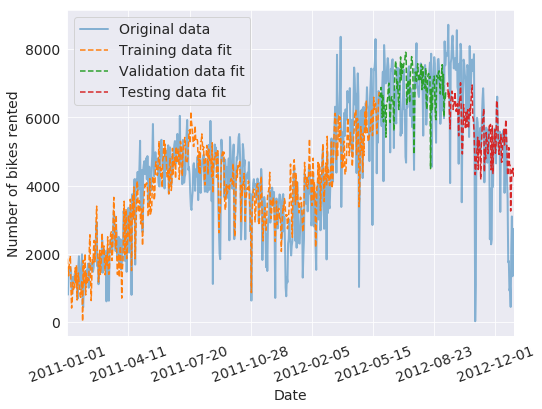

In [21]:
# rember this is the model:
# train a linear regression model
lr = LinearRegression().fit(X_train_pp,y_train)

# make predictions
y_train_pred = lr.predict(X_train_pp)
y_valid_pred = lr.predict(X_valid_pp)
y_test_pred = lr.predict(X_test_pp)

# set up figure
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))
# plot original and predicted data
data.plot("dteday", "cnt",rot=20,fontsize=14,ax=ax,label="Original data",lw=2,alpha=0.5)
x_data = ax.get_children()[0].get_xdata()
ax.plot(x_data[:train_idx],y_train_pred,"--",label="Training data fit")
ax.plot(x_data[train_idx:valid_idx],y_valid_pred,"--",label="Validation data fit")
ax.plot(x_data[valid_idx:],y_test_pred,"--",label="Testing data fit")
# add labels
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel("Number of bikes rented",fontsize=14)
_ = ax.legend(fontsize=14)

# print some scores again
print(f"Training\tR2:\t{r2_score(y_train, y_train_pred):.2f}\tMAE:\t{mean_absolute_error(y_train, y_train_pred)}\n\
Validation\tR2:\t{r2_score(y_valid, y_valid_pred):.2f}\tMAE:\t{mean_absolute_error(y_valid, y_valid_pred)}\n\
Testing\t\tR2:\t{r2_score(y_test, y_test_pred):.2f}\tMAE:\t{mean_absolute_error(y_test, y_test_pred)}")

The model already captures the overall and seasonal trends quite well. However, it still seems to have problems following the strong local fluctuations, for example around July-August 2011 or around August-October 2012.

If we want to think about improving a model, we need a baseline to compare the new versions to. The simple linear regression above has already provided such a baseline. Another good idea is to make a simple common sense prediction without any fancy modeling. For example, for time series data, the values ofetn show strong local correlations. The number of bikes rented today may be pretty similar to yesterday. Therefore, let's see what baseline we get if I just predict the same number as 24 hours earlier.

In [22]:
# predict the same number of rentals as the previous day
y_true = data.cnt[1:]
y_pred = data.cnt.shift(1)[1:]

# calculate R2 and MAE
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
print(f"R2: {r2:.2f}\nMAE: {mae:.2f}")

R2: 0.70
MAE: 729.88


The simple linear regression model already performs better than this common sense baseline (on the training data, for validation and test data this is not comparable). To further improve the model, I will try two approaches: First I will try to extend the simple linear regression model, then I will try a completely different approach with time series auto-regression.

To extend the linear regression I will consider adding polynomial features. Linear regression (as the name already tells)  just linearly combines feature. If we want to express non-linear dependencies or interactions between features, we can just add these terms as additional features to the linear regression model. Furthermore, I will add regularization. Regularization tries to hinder over-fitting on the training data by restricting the values of the fitted coefficients. This can be done by panelization of the absolute (l1-type, also called lasso) or squared (l2-type, also called ridge) values of the coefficients, or using a combination of both (elastic net type).

In [23]:
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# write a new preprocessor that creates polynomial features for the numerical features
# and then standardizes them, categorical feature get just passed through
preprocess = ColumnTransformer(transformers=[
    ("cat", "passthrough", ["yr","mnth","workingday","weathersit"]),
    ("num", Pipeline(steps=[
        ("poly", PolynomialFeatures(degree=1)),
        ("std", StandardScaler())
    ]),["atemp","windspeed"])])

# combine the preprocsessing with the elastic-net-regularized linear regression in a pipeline
estimator = Pipeline(steps=[
        ("prep", preprocess),
        ("enlr", ElasticNet(alpha=0.1,l1_ratio=0.5,max_iter=10000000))
])

The hyper-parameters to be tuned here are the degree of the polynomial features, the regularization coefficient, alpha, and the ratio between l1 and l2 regularization. 

For hyper-parameter optimization performs one usually performs a search over a given parameter space, looking for the best cross-validation score. A k-fold cross-validation means that a model is trained with the same settings k times but each time a different parts of the training data is put aside as a validation set and the average validation score is calculated. Since we work with time series data, these validation sets can not just chosen randomly (as it is usually done). For time series data, one can perform so-called sliding window or forward-chain cross-validation. For this very small data set, however, there is relatively little training data left to reasonably train a model if these techniques are used. Therefore I split of a validation set in the beginning an I will perform only one validation step on this set. This is arguably not the best way to approach the problem, but I'll stick to it here for simplicity.

To perform the  search over the parameter space, one can, e.g., either specify a grid with predefined values or define a range and pick values from it randomly for a certain number of iterations. Neither of these methods is particularly clever because it doesn't consider if going in a particular direction of the search space may result in a better score. To build somewhat of a surrogate probability model that tries to go into the best direction of the search space for a given number of iterations, one can use a bayesian search. This is what I will do here. 

In [24]:
from sklearn.model_selection import PredefinedSplit
from skopt import BayesSearchCV

# we will have to tell the optimizer that we 
# already have a predefined validation set
valid_fold_idx = -1 * np.ones(shape=len(selected_data))
valid_fold_idx[train_idx:valid_idx] = 0
ps = PredefinedSplit(test_fold=valid_fold_idx)


# this will be the search space for the hyper-parameters
search_spaces = {"prep__num__poly__degree": (1, 4),  
                 "enlr__alpha": (1e-4, 1e+1, "log-uniform"),
                 "enlr__l1_ratio": (0.0, 1.0,"uniform")}

# Set up the baysian search with the pipeline estimator that
# already contains the preprocessing and use the predefined
# search spaces and validation set split, use 32 iterations.
opt = BayesSearchCV(
    estimator,
    search_spaces=search_spaces,
    scoring="neg_mean_absolute_error",
    n_iter=32,
    cv=ps
)

opt.fit(selected_data.drop("cnt",axis=1), selected_data.cnt)


# print the best results
print(f"Best validation MAE: {-1*opt.best_score_}\nBest paramters:\n{opt.best_params_}")

Best validation MAE: 555.2271147891081
Best paramters:
{'enlr__alpha': 0.00018530352073579712, 'enlr__l1_ratio': 0.24651291211446874, 'prep__num__poly__degree': 4}


This does already look very promising. Let's compare the current to the previous results.

Training	R2:	0.80	MAE:	540.1397705281147
Validation	R2:	0.32	MAE:	541.0742579780576
Testing		R2:	0.65	MAE:	920.629088448288


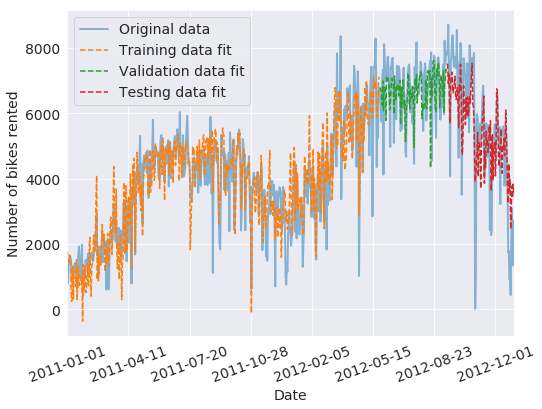

In [25]:
# make predictions
y_train_pred = opt.predict(X_train)
y_valid_pred = opt.predict(X_valid)
y_test_pred = opt.predict(X_test)

# set up figure
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))
# plot original and predicted data
data.plot("dteday", "cnt",rot=20,fontsize=14,ax=ax,label="Original data",lw=2,alpha=0.5)
x_data = ax.get_children()[0].get_xdata()
ax.plot(x_data[:train_idx],y_train_pred,"--",label="Training data fit")
ax.plot(x_data[train_idx:valid_idx],y_valid_pred,"--",label="Validation data fit")
ax.plot(x_data[valid_idx:],y_test_pred,"--",label="Testing data fit")
# add labels
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel("Number of bikes rented",fontsize=14)
_ = ax.legend(fontsize=14)

# calculate R2 and MAE and print results
print(f"Training\tR2:\t{r2_score(y_train, y_train_pred):.2f}\tMAE:\t{mean_absolute_error(y_train, y_train_pred)}\n\
Validation\tR2:\t{r2_score(y_valid, y_valid_pred):.2f}\tMAE:\t{mean_absolute_error(y_valid, y_valid_pred)}\n\
Testing\t\tR2:\t{r2_score(y_test, y_test_pred):.2f}\tMAE:\t{mean_absolute_error(y_test, y_test_pred)}")

After hyper-parameter optimization, this improved model clearly outperforms both the common sense baseline as well as the previous simple linear regression model. I is following the local fluctuations much better and the training and validation scores are much better. The test score is better as well, but the error is still much higher than the train or validation scores. That is a clear sign that the optimization has over-fitted the validation set to some degree. That's why cross-validation would be a good idea if more data was available.

Now I will try the second approach I mentioned, a time series auto-regression. But first I have to say a few word on stationary time series. Most time series data (and this one here as well) show some overall trend and some form of seasonality trends. That means it is not stationary because statistical properties such as mean and variance do not remain constant over time and the autocovariance likely depends on time as well. For many time series forecasting model we do, however, need a stationary time series to fulfill the assumptions.

We can test if a time series is stationary with the Dickey-Fuller Test. If the test statistic is less than the a critical value (say 0.05), I will reject the null hypothesis and say that the series is stationary.

In [26]:
from statsmodels.tsa.stattools import adfuller

# first convert the date column to datetime data format
data.dteday = pd.to_datetime(data.dteday)

# Dickey-Fuller test
ts = data.set_index("dteday").cnt.copy()
dftest = adfuller(ts, autolag='AIC')

# print result
print(f"Test statistic: {dftest[0]}\np-value: {dftest[1]}")

Test statistic: -1.8774481444374287
p-value: 0.3427434403392199


I will chose 0.05 as a significance level and conclude that, since the p-value of 0.34 is much higher than 0.05, the time series is not stationary (which we kind of knew already from looking at the plots). To make the time series stationary, I will have to remove the overall and seasonal trend. There are, again, a couple of approaches using differencing, aggregations, rolling averages, or polynomial fits, or special seasonal decompositions. I'll use the latter.

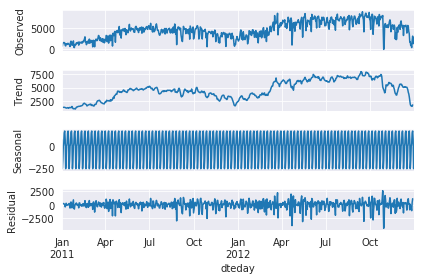

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

# perform a seasonal decomposition
decomposition = seasonal_decompose(ts)
residual = decomposition.resid

# the residuals are the decomposed timseries 
ts_decomposed = residual.dropna()

# plot the original data, trend, seasonality, and residuals
_ = decomposition.plot().gca()

Now I will test again if the time series is stationary now.

In [28]:
# perform another Dickey-Fuller test
dftest = adfuller(ts_decomposed, autolag='AIC')
print(f"Test statistic: {dftest[0]}\np-value: {dftest[1]}")

Test statistic: -11.952547293815142
p-value: 4.283319262618949e-22


The p-value is far below 0.05 and I conclude that the time series is stationary now. Since in a time series, there is usually a strong dependence among values, one needs to use a statistical models like ARIMA (Auto-Regressive Integrated Moving Averages) to predict the data. First I need to find the correct number of auto-regressive (AR) parameters, p, and moving average (MA) parameters, q. This can be done by looking at plots of the auto-correlation function (ACF) and the partial auto-correlation function (PACF) and see where these functions cross the upper boundaries of (e.g. 0.95) confidence intervals around zero.

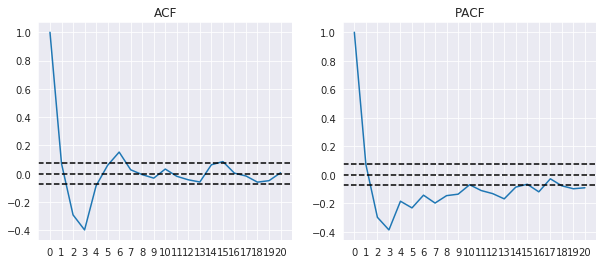

In [29]:
from statsmodels.tsa.stattools import acf, pacf

# calculate ACF and PACF
lag_acf = acf(ts_decomposed, nlags=20)
lag_pacf = pacf(ts_decomposed, nlags=20, method='ols')

# set up subplot
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,4))

# plot ACF + confidence interval around 0
ax1.plot(lag_acf)
ax1.set_xticks(range(len(lag_acf)))
ax1.axhline(y=0,linestyle='--',c="k")
ax1.axhline(y=-1.96/np.sqrt(len(ts_decomposed)),linestyle='--',c="k")
ax1.axhline(y=1.96/np.sqrt(len(ts_decomposed)),linestyle='--',c="k")
ax1.set_title("ACF")

# plot PACF + confidence interval around 0
ax2.plot(lag_pacf)
ax2.set_xticks(range(len(lag_pacf)))
ax2.axhline(y=0,linestyle='--',c="k")
ax2.axhline(y=-1.96/np.sqrt(len(ts_decomposed)),linestyle='--',c="k")
ax2.axhline(y=1.96/np.sqrt(len(ts_decomposed)),linestyle='--',c="k")
_ = ax2.set_title("PACF")

Both functions cross the confidence interval at 1, so I will choose p=1 and q=1. I will now fit an ARIMA model to the time series.

Training	R2:	0.41	MAE:	866.5370003025499
Valid+test	R2:	0.55	MAE:	805.3803658475065



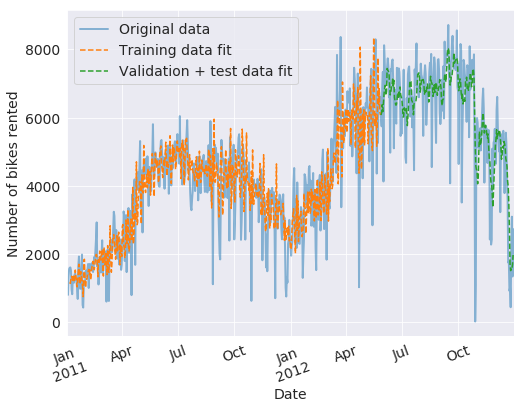

In [30]:
from statsmodels.tsa.arima_model import ARIMA

# order = (p,d,q) means number or AR parameters, differences, and MA parameters to use
# only fit on the training data
model_ARIMA = ARIMA(ts.iloc[:train_idx], order=(1, 1, 1),freq="D")  
results_ARIMA = model_ARIMA.fit(disp=-1)  # -1 means: don't print any convergence info

# make predictions
y_train_pred = (results_ARIMA.predict(1,train_idx,ts) 
                + decomposition.seasonal 
                + decomposition.trend).dropna()
# let's put validation and test set together now
y_validtest_pred = (results_ARIMA.predict(train_idx,len(ts),ts) 
                + decomposition.seasonal 
                + decomposition.trend).dropna()

# set up figure
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))
# plot original and predicted data
data.plot("dteday", "cnt",rot=20,fontsize=14,ax=ax,label="Original data",lw=2,alpha=0.5)
x_data = ax.get_children()[0].get_xdata()[2:]
ax.plot(x_data[2:train_idx],y_train_pred,"--",label="Training data fit")
ax.plot(x_data[train_idx:-1],y_validtest_pred,"--",label="Validation + test data fit")

# add labels
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel("Number of bikes rented",fontsize=14)
_ = ax.legend(fontsize=14)

# calculate R2 and MAE and print results
print(f"Training\tR2:\t{r2_score(y_train[2:], y_train_pred):.2f}\tMAE:\t\
{mean_absolute_error(y_train[2:], y_train_pred)}\n\
Valid+test\tR2:\t{r2_score(y_valid.append(y_test)[3:], y_validtest_pred):.2f}\t\
MAE:\t{mean_absolute_error(y_valid.append(y_test)[3:], y_validtest_pred)}\n")

The time series auto-regression does also capture the overall and seasonal trends but the coefficient of determination is lower and the error is higher compared to the previous linear regression model. This is not surprising considering that we only used the shape of the time series itself, whereas we used all other features in the linear regression model. The time series auto-regression may, hence, be a good alternative for tasks where not many informative features are available.

## 4. Query the data with SQL and pandas <a id="q4"></a>
> *"Consider this data was in an SQL table with features as columns. Write the SQL statement to get the average daily number of shared bikes monthly (calculate also variance of daily shared bikes for each month in two years). Do the same with pandas. Plot the distribution of average daily number of shared bikes against month/year (x-axis is the month/year)."*

To query something from an SQL table, I'll use the `pandasql` library which allows to query a `pandas` data frame as if it was a SQL table.

In [31]:
import pandasql as ps

# In the SQL query I group by the months of the two years and select as columns
# the date (month/year), average amount of bike rents and the variance of bike rents.
# The since for the variance two aggregation functions (AVG and SUM) are needed, I have
# to get the average over a sub-query and the sum in the main query.
query = """
SELECT 
STRFTIME("%m-%Y", dteday) AS date, 
AVG(cnt) AS average,
SUM((cnt-(SELECT AVG(cnt) FROM data GROUP BY STRFTIME("%m-%Y", dteday)))*
    (cnt-(SELECT AVG(cnt) FROM data GROUP BY STRFTIME("%m-%Y", dteday)))) 
    / (COUNT(cnt)-1) AS variance
FROM data 
GROUP BY STRFTIME("%m-%Y", dteday)
"""

# execute the query on the "data" data frame
ps.sqldf(query, locals())

,date,average,variance
0,01-2011,1231.903226,1.387061e+05
1,01-2012,3120.774194,4.448632e+06
2,02-2011,1721.964286,4.078639e+05
3,02-2012,3556.448276,6.354654e+06
4,03-2011,2065.967742,1.022422e+06
5,03-2012,5318.548387,1.882277e+07
6,04-2011,3162.333333,4.941022e+06
7,04-2012,5807.466667,2.337103e+07
8,05-2011,4381.322581,1.057772e+07
9,05-2012,6318.225806,2.789599e+07


Now let's do the same with `pandas` build-in functions (which I think are a bit more handy):

In [32]:
# first convert the date column to datetime data format
data.dteday = pd.to_datetime(data.dteday)

# group the data by the date column with a monthl frequency,
# apply average (mean) and variance aggregation functions
# and then select the "cnt" (count of rentals) columns
data_agg = data.groupby(pd.Grouper(key="dteday",
                                   freq="M")).agg(["mean","var"]).cnt.reset_index()
data_agg

,dteday,mean,var
0,2011-01-31,1231.903226,1.387061e+05
1,2011-02-28,1721.964286,1.588093e+05
2,2011-03-31,2065.967742,3.035698e+05
3,2011-04-30,3162.333333,1.085959e+06
4,2011-05-31,4381.322581,3.282464e+05
5,2011-06-30,4783.733333,1.975339e+05
6,2011-07-31,4559.387097,4.625234e+05
7,2011-08-31,4409.387097,6.558609e+05
8,2011-09-30,4247.266667,9.319532e+05
9,2011-10-31,3984.225806,1.217672e+06


Now I will plot the average data as a function of time and use the standard deviation (square root of the variance) to show the spread of the data around the mean.

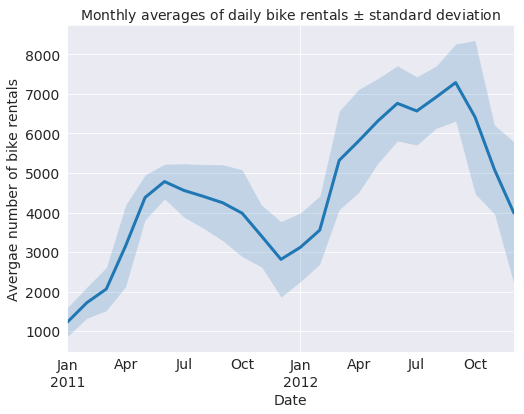

In [33]:
# set up figure
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 6))
# plot the data
data_agg.plot("dteday",
              "mean",
              ax=ax,
              fontsize=14,
              legend=False,
              linewidth=3,
              label="Average daily bike rentals +/- std. dev.")
# plot the standard deviation band
ax.fill_between(x=ax.get_children()[0].get_xdata(),
                y1=data_agg["mean"] + np.sqrt(data_agg["var"]),
                y2=data_agg["mean"] - np.sqrt(data_agg["var"]),
                alpha=0.2)
# add labels
ax.set_title("Monthly averages of daily bike rentals $\pm$ standard deviation",fontsize=14)
ax.set_ylabel("Avergae number of bike rentals",fontsize=14)
_ = ax.set_xlabel("Date",fontsize=14)

## 5. Merging existing and new data with SQL and pandas <a id="q5"></a>
> *"Consider you had another file with the following fields:*
```
- dteday : date
- traffic : 0 for low 1 for medium 2 for high
```
> *Assume you might not have data for all days for this table. How would you merge this
new data with the existing data? Explain with pandas and SQL. How would you
preprocess this new feature before training your linear model?"*

First I will create this additional data. Since I don't know the usual traffic patterns I will make a simplifying  assumption and assign the traffic situation randomly. In reality, there may be differences e.g. between working day commuter traffic and weekend/holiday traffic. To account for potentially missing data, I will remove some of the values randomly.

In [34]:
# create randomly assigned traffic data
traffic_data = data[["dteday"]].merge(
               pd.DataFrame(np.random.randint(0,3,size=len(data.dteday)),
                            columns=["traffic"]),
               left_index=True,
               right_index=True)

# randomly remove (set to NaN) a fraction of 10% of the entries
idx = np.random.randint(0,len(data.dteday),size=int(len(data.dteday)*0.1))
traffic_data.loc[idx,"traffic"] = np.NaN

# have a look at the data
traffic_data.sample(15)

,dteday,traffic
461,2012-04-06,0.0
721,2012-12-22,2.0
477,2012-04-22,1.0
36,2011-02-06,2.0
10,2011-01-11,1.0
550,2012-07-04,0.0
255,2011-09-13,2.0
612,2012-09-04,NaN
89,2011-03-31,2.0
321,2011-11-18,1.0


Now I'll merge this  data with the previous data using SQL.

In [35]:
# In the SQL query I perform an inner join of the two tables "data"
# and "traffic_data" and select all columns from "data" and the 
# traffic column from "traffic_data"
query = """
SELECT d.*, td.traffic
FROM data d INNER JOIN traffic_data td
ON d.dteday = td.dteday
"""

# execute the query and look at the first few lines
ps.sqldf(query, locals()).head(10)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,traffic
0,1,2011-01-01 00:00:00.000000,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,0.0
1,2,2011-01-02 00:00:00.000000,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,1.0
2,3,2011-01-03 00:00:00.000000,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,1.0
3,4,2011-01-04 00:00:00.000000,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,0.0
4,5,2011-01-05 00:00:00.000000,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,2.0
5,6,2011-01-06 00:00:00.000000,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.089565,88,1518,1606,2.0
6,7,2011-01-07 00:00:00.000000,1,0,1,0,5,1,2,0.196522,0.208839,0.498696,0.168726,148,1362,1510,NaN
7,8,2011-01-08 00:00:00.000000,1,0,1,0,6,0,2,0.165000,0.162254,0.535833,0.266804,68,891,959,0.0
8,9,2011-01-09 00:00:00.000000,1,0,1,0,0,0,1,0.138333,0.116175,0.434167,0.361950,54,768,822,0.0
9,10,2011-01-10 00:00:00.000000,1,0,1,0,1,1,1,0.150833,0.150888,0.482917,0.223267,41,1280,1321,1.0


Now I'll do the same thing again with `pandas`.

In [36]:
# merge the two data frames
merged_data = data.merge(traffic_data,left_on="dteday",right_on="dteday")
merged_data.head(10)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,traffic
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,0.0
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,1.0
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,1.0
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,0.0
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,2.0
5,6,2011-01-06,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.089565,88,1518,1606,2.0
6,7,2011-01-07,1,0,1,0,5,1,2,0.196522,0.208839,0.498696,0.168726,148,1362,1510,NaN
7,8,2011-01-08,1,0,1,0,6,0,2,0.165000,0.162254,0.535833,0.266804,68,891,959,0.0
8,9,2011-01-09,1,0,1,0,0,0,1,0.138333,0.116175,0.434167,0.361950,54,768,822,0.0
9,10,2011-01-10,1,0,1,0,1,1,1,0.150833,0.150888,0.482917,0.223267,41,1280,1321,1.0


If this data should be used in a machine learning model, one has to consider that the `traffic` feature contains missing values.

In [37]:
print("Number of missing values in the traffic column:",merged_data.traffic.isna().sum())

Number of missing values in the traffic column: 68


I already discussed how missing values can be handled in question [3a](#q3a). We could either drop these instances or try to impute the missing values by the most frequent value, the mean, or the median. Since the values are ordinal and not nominal or continuous, I think the median makes most sense. Forward, backward, or rolling window filling may also be an option. Let's have a look how that could be done:

In [38]:
# Scikit-learn offers a SimpleImputer
from sklearn.impute import SimpleImputer

# impute with median value
imp_traffic = SimpleImputer(strategy="median").fit_transform(merged_data[["traffic"]])

print("Missing values:",len(imp_traffic[imp_traffic==np.NaN]))

Missing values: 0


This can also be done with `pandas` in various ways:

In [39]:
# first get the missing values, then impute them

# impute with the median
missing = merged_data.traffic[merged_data.traffic.isna()].copy()
missing[:] = merged_data.traffic.median()

# impute working day and non-workingday differently
# working days
missing_wd = merged_data.loc[(merged_data.workingday==1)&merged_data.traffic.isna(),
                             "traffic"].copy()
missing_wd[:] = merged_data.loc[(merged_data.workingday==1),
                                "traffic"].median()
# non-working days
missing_nwd = merged_data.loc[(merged_data.workingday==0)&merged_data.traffic.isna(),
                             "traffic"].copy()
missing_nwd[:] = merged_data.loc[(merged_data.workingday==0),
                                "traffic"].median()

# use forward or backward filling
# forward
missing = merged_data.traffic.copy().fillna(method="ffill")
# backward
missing = merged_data.traffic.copy().fillna(method="bfill")

# fill with a rolling window median
rolling_median = merged_data.traffic.rolling(window=6, min_periods=1).median()
missing = merged_data.traffic[merged_data.traffic.isna()].copy()
missing[:] = rolling_median.iloc[missing[:].index]

Which strategy for handling missing values performs best depends on the structure of the real data. Anyway, it can be considered for hyper-parameter optimization.

## Conclusion <a id="con"></a>

In this technical challenge I discussed many topics around making future predictions for a bike rentals of a bike sharing program. I talked about usefulness of data for training a predictive model, the treatment of variables/features, training a linear regression model, as well as querying and merging data with SQL and pandas.

I hope I provided some interesting information and I would be glad if you would consider me for the position.

If you would like to see more of my work, feel free to have a look at projects on my [GitHub](https://github.com/Pascal-Bliem), for example my end-to-end data science project on the latest [European Social Survey](https://github.com/Pascal-Bliem/european-social-survey), a discussion on [error rate control](https://github.com/Pascal-Bliem/error-control-statistical-tests) in statistical testing, or my exploration of specific smaller [machine learning topics](https://github.com/Pascal-Bliem/exploring-the-UCI-ML-repository) on lesser know data sets.

Thanks a lot for following me all the way though this notebook!